# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
from sklearn.model_selection import learning_curve,StratifiedKFold
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_data=pd.read_csv("orange_small_churn_data.csv")
name=['target']
target=pd.read_csv("orange_small_churn_labels.csv",names=name)
df_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN


##### Drop the columns with 100% of missings

In [3]:
to_drop=[]
for i in df_data.columns:
    if df_data.isna().sum()[i]/df_data.shape[0]==1:
#         print(i,df_data.isna().sum()[i]/df_data.shape[0])
        to_drop.append(i)
df_data.drop(columns=to_drop,inplace=True)
df_data.shape

(40000, 212)

__Creating the hold-out dataset__


In [4]:
X_train, hold_out, y_train, y_test = train_test_split(df_data, target['target'], test_size=0.2, random_state=42)

__Based on expert judgment the treshold=75% was selected__

In [5]:
to_drop_75=[]
for i in X_train.columns:
    if X_train.isna().sum()[i]/X_train.shape[0]>0.75:
        to_drop_75.append(i)
X_train.drop(columns=to_drop_75,inplace=True)
X_train.shape

(32000, 76)

In [6]:
# for future testing we create the copy of train and test samples
X_train_no_prep=X_train.copy()
hold_out_no_prep=hold_out.copy()

__Preprocessing__

In [7]:
# Numeric columns
X_train.loc[:,'Var6':'Var189'] = X_train.loc[:,'Var6':'Var189'].fillna(X_train.loc[:,'Var6':'Var189'].mean())

In [8]:
# Let's find the categorical features for which the number of unique values in the training and test samples is the same
train={}
for i in X_train.loc[:,'Var192':'Var229'].columns:
    train[i]=len(X_train[i].unique())
test={}
for i in hold_out.loc[:,'Var192':'Var229'].columns:
    test[i]=len(hold_out[i].unique())

After checking the following columns were found:  
__'Var194','Var201','Var204','Var205','Var208','Var210','Var211','Var218','Var221','Var223','Var225','Var226',
          'Var227','Var229'__

In [9]:
# preprocessing categorical data
categ_col=['Var194','Var201','Var204','Var205','Var208','Var210','Var211','Var218','Var221','Var223','Var225','Var226',
          'Var227','Var229']
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train.drop(columns=col_to_drop,inplace=True)

# creating the final training sample
X_train[categ_col]=X_train[categ_col].fillna(-100)
dummy=pd.get_dummies(X_train[categ_col])
X_train_no_categ=X_train.drop(columns=categ_col)
X_train_fin=pd.concat([X_train_no_categ,dummy],axis=1)

In [10]:
# Creating the final hold-out-sample
hold_out.loc[:,'Var6':'Var189'] = hold_out.loc[:,'Var6':'Var189'].fillna(hold_out.loc[:,'Var6':'Var189'].mean())
categ_col=['Var194','Var201','Var204','Var205','Var208','Var210','Var211','Var218','Var221','Var223','Var225','Var226',
          'Var227','Var229']
col_to_drop=[]
for i in test.keys():
    if i not in categ_col:
        col_to_drop.append(i)
hold_out.drop(columns=col_to_drop,inplace=True)

hold_out[categ_col]=hold_out[categ_col].fillna(-100)
dummy=pd.get_dummies(hold_out[categ_col])
hold_out_no_cat=hold_out.drop(columns=categ_col)
hold_out_fin=pd.concat([hold_out_no_cat,dummy],axis=1)

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

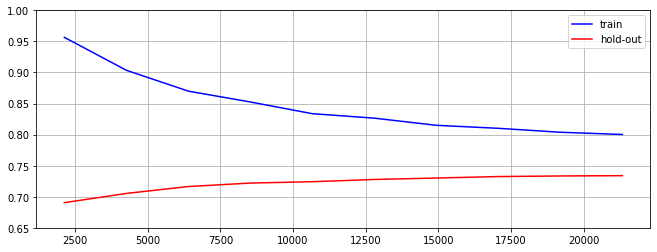

In [27]:
clf = xgb.XGBClassifier(random_state=9)
train_sizes, train_scores, test_scores = learning_curve(clf, X_train_fin, y_train, train_sizes=np.linspace(0.1,1.0,10),
                                                        cv=StratifiedKFold(n_splits=3, shuffle=True),
                                                        scoring='roc_auc', n_jobs=-1)
plt.figure(figsize=(11, 4))
plt.grid(True)
plt.plot(train_sizes, train_scores.mean(axis = 1), 'b',  label='train')
plt.plot(train_sizes, test_scores.mean(axis = 1), 'r-',  label='hold-out')
plt.ylim((0.65, 1.0))
plt.legend(loc='upper right')

__Conclusion: The learning curve continues to decrease as the number of objects grows, but the test curve grows significantly up to 7500 and then continues to grow weakly up to 17500 objects. 
It can be concluded that 12500-17500 objects of the training sample are enough to build a high-quality model__

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [32]:
y_train.value_counts(normalize=True)

-1    0.926406
 1    0.073594
Name: target, dtype: float64

Let's change the __scale_pos_weight__

In [58]:
res = {}
for weight in [1.0, 1.5, 2.5, 4.0, 8.5, 12.5, 19.0, 37.5]:
    clf = xgb.XGBClassifier( random_state=9,scale_pos_weight=weight)
    res[weight]=cross_val_score(clf,  X_train_fin, y_train, scoring='roc_auc', 
                                cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()
res

{1.0: 0.734541115233449,
 1.5: 0.7342709357831954,
 2.5: 0.7316413710125286,
 4.0: 0.7335700885715983,
 8.5: 0.7379852530213905,
 12.5: 0.7293619865030997,
 19.0: 0.7305089341699845,
 37.5: 0.7219346756197726}

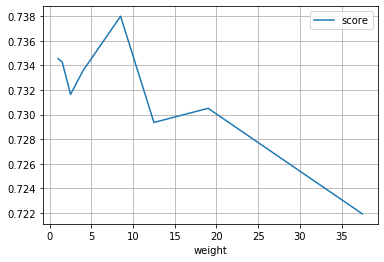

In [59]:
plt.plot(list(res.keys()), list(res.values()),label='score')
plt.xlabel('weight')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

__Conclusion: Imbalance towards class -1 ( 8.5) has showed the best result__

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [17]:
# 1-RandomUnderSampler
# 2-EditedNearestNeighbours
# 3-NeighbourhoodCleaningRule
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
under_firts= NeighbourhoodCleaningRule()
under_second=EditedNearestNeighbours(sampling_strategy="not minority")
under_third=NeighbourhoodCleaningRule()
X_res1, y_res1 = under_firts.fit_resample(X_train_fin, y_train)
X_res2, y_res2 = under_second.fit_resample(X_train_fin, y_train)
X_res3, y_res3 = under_third.fit_resample(X_train_fin, y_train)

In [26]:
clf = xgb.XGBClassifier(random_state=9)
print('ROC-AUC with using RandomUnderSampler = {}'.format(cross_val_score(clf, 
                                                                          X_res1, y_res1, 
                                                                          scoring='roc_auc', 
                                                                          cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()))
print('ROC-AUC with using EditedNearestNeighbours = {}'.format(cross_val_score(clf, 
                                                                          X_res2, y_res2, 
                                                                          scoring='roc_auc', 
                                                                          cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()))
print('ROC-AUC with using NeighbourhoodCleaningRule = {}'.format(cross_val_score(clf, 
                                                                          X_res3, y_res3, 
                                                                          scoring='roc_auc', 
                                                                          cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()))



ROC-AUC with using RandomUnderSampler = 0.7340507685103966
ROC-AUC with using EditedNearestNeighbours = 0.7445370214010408
ROC-AUC with using NeighbourhoodCleaningRule = 0.7382427744482323


__Conclusion__: All of three methods have shown the similar results, but the EditedNearestNeighbours method has the highest ROC-AUC

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Let's fill missings with 3 different approaches:  
1.__mean__  
2.__median__  
3.__zero filling__

In [13]:
# MEAN
X_train_mean=X_train_no_prep.copy()

# Numeric columns
X_train_mean.loc[:,'Var6':'Var189'] = X_train_mean.loc[:,'Var6':'Var189'].fillna(X_train_mean.loc[:,'Var6':'Var189'].mean())
# preprocessing categorical data
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train_mean.drop(columns=col_to_drop,inplace=True)

# creating the final training sample
X_train_mean[categ_col]=X_train_mean[categ_col].fillna(-100)
dummy=pd.get_dummies(X_train_mean[categ_col])
X_train_mean_no_categ=X_train_mean.drop(columns=categ_col)
X_train_mean_fin=pd.concat([X_train_mean_no_categ,dummy],axis=1)

# Modelling
clf = xgb.XGBClassifier(random_state=9)
print('ROC-AUC with using mean filling = {}'.format(cross_val_score(clf, 
                                                                          X_train_mean_fin, y_train, 
                                                                          scoring='roc_auc', 
                                                                          cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()))



ROC-AUC with using mean filling = 0.7330860686128542


In [14]:
X_train_median=X_train_no_prep.copy()
X_train_median.loc[:,'Var6':'Var189'] = X_train_median.loc[:,'Var6':'Var189'].fillna(X_train_median.loc[:,'Var6':'Var189'].median())
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train_median.drop(columns=col_to_drop,inplace=True)

# creating the final training sample
X_train_median[categ_col]=X_train_median[categ_col].fillna(-100)
dummy=pd.get_dummies(X_train_median[categ_col])
X_train_median_no_categ=X_train_median.drop(columns=categ_col)
X_train_median_fin=pd.concat([X_train_median_no_categ,dummy],axis=1)

# Modelling
clf = xgb.XGBClassifier(random_state=9)
print('ROC-AUC with using median filling = {}'.format(cross_val_score(clf, 
                                                                          X_train_median_fin, y_train, 
                                                                          scoring='roc_auc', 
                                                                          cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()))



ROC-AUC with using median filling = 0.7270283148804491


In [15]:
X_train_zero=X_train_no_prep.copy()
X_train_zero.loc[:,'Var6':'Var189'] = X_train_zero.loc[:,'Var6':'Var189'].fillna(0)
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train_zero.drop(columns=col_to_drop,inplace=True)

# creating the final training sample
X_train_zero[categ_col]=X_train_zero[categ_col].fillna(-100)
dummy=pd.get_dummies(X_train_zero[categ_col])
X_train_zero_no_categ=X_train_zero.drop(columns=categ_col)
X_train_zero_fin=pd.concat([X_train_zero_no_categ,dummy],axis=1)

# Modelling
clf = xgb.XGBClassifier(random_state=9)
print('ROC-AUC with using zero filling = {}'.format(cross_val_score(clf, 
                                                                          X_train_zero_fin, y_train, 
                                                                          scoring='roc_auc', 
                                                                          cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()))





ROC-AUC with using zero filling = 0.7348443990850791


__Conclusion__: The filling missings with zero values has showed the highest ROC-AUC 

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Let's fill missings with 3 different approaches:   
1.__get_dummies ( OneHotEncoder)__  
2.__OrdinalEncoder__  
3.__HashingEncoder__

In [11]:
# OneHotEncoder
X_train_mean=X_train_no_prep.copy()

# Numeric columns
X_train_mean.loc[:,'Var6':'Var189'] = X_train_mean.loc[:,'Var6':'Var189'].fillna(X_train_mean.loc[:,'Var6':'Var189'].mean())
# preprocessing categorical data
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train_mean.drop(columns=col_to_drop,inplace=True)

# creating the final training sample
X_train_mean[categ_col]=X_train_mean[categ_col].fillna(-100)
dummy=pd.get_dummies(X_train_mean[categ_col])
X_train_mean_no_categ=X_train_mean.drop(columns=categ_col)
X_train_mean_fin=pd.concat([X_train_mean_no_categ,dummy],axis=1)

# Modelling
clf = xgb.XGBClassifier(random_state=9)
print('ROC-AUC with get_dummies = {}'.format(cross_val_score(clf, 
                                                                          X_train_mean_fin, y_train, 
                                                                          scoring='roc_auc', 
                                                                          cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()))


ROC-AUC with get_dummies = 0.7350061592196688


In [22]:
# OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
X_train_mean=X_train_no_prep.copy()

# Numeric columns
X_train_mean.loc[:,'Var6':'Var189'] = X_train_mean.loc[:,'Var6':'Var189'].fillna(X_train_mean.loc[:,'Var6':'Var189'].mean())
# preprocessing categorical data
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train_mean.drop(columns=col_to_drop,inplace=True)


X_train_mean[categ_col]=X_train_mean[categ_col].fillna('-100')
enc_1=OrdinalEncoder()
enc_1.fit(X_train_mean[categ_col])
X_train_mean[categ_col]=enc_1.transform(X_train_mean[categ_col])

# Modelling
clf = xgb.XGBClassifier(random_state=9)
print('ROC-AUC with OrdinalEncoder = {}'.format(cross_val_score(clf, 
                                                                          X_train_mean, y_train, 
                                                                          scoring='roc_auc', 
                                                                          cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()))



ROC-AUC with OrdinalEncoder = 0.7342740369254847


In [26]:
from category_encoders import HashingEncoder
X_train_mean=X_train_no_prep.copy()

# Numeric columns
X_train_mean.loc[:,'Var6':'Var189'] = X_train_mean.loc[:,'Var6':'Var189'].fillna(X_train_mean.loc[:,'Var6':'Var189'].mean())
# preprocessing categorical data
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train_mean.drop(columns=col_to_drop,inplace=True)


X_train_mean[categ_col]=X_train_mean[categ_col].fillna('-100')
enc_2=HashingEncoder()
enc_2.fit(X_train_mean[categ_col])
X_train_mean[categ_col]=enc_1.transform(X_train_mean[categ_col])

clf = xgb.XGBClassifier(random_state=9)
print('ROC-AUC with HashingEncoder = {}'.format(cross_val_score(clf, 
                                                                          X_train_mean, y_train, 
                                                                          scoring='roc_auc', 
                                                                          cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()))


ROC-AUC with HashingEncoder = 0.732228055111432


__Conclusion__: All of three methods have shown the similar results, but the OneHotEncoding method has the highest ROC-AUC

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

Let's making feature selection with 2 different approaches:  
1.with model XGBoost  
2.sklearn.linear_model.Lasso

In [38]:
X_train_mean=X_train_no_prep.copy()

# Numeric columns
X_train_mean.loc[:,'Var6':'Var189'] = X_train_mean.loc[:,'Var6':'Var189'].fillna(X_train_mean.loc[:,'Var6':'Var189'].mean())
# preprocessing categorical data
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train_mean.drop(columns=col_to_drop,inplace=True)

# creating the final training sample
X_train_mean[categ_col]=X_train_mean[categ_col].fillna(-100)
dummy=pd.get_dummies(X_train_mean[categ_col])
X_train_mean_no_categ=X_train_mean.drop(columns=categ_col)
X_train_mean_fin=pd.concat([X_train_mean_no_categ,dummy],axis=1)


thershold=0.01
clf = xgb.XGBClassifier(random_state=9)
clf.fit(X_train_mean_fin,y_train)
new_vars = X_train_mean_fin.columns[clf.feature_importances_ > thershold]
df_after_selection = X_train_mean_fin[new_vars]
print(f'Number of columns after feature selection={len(new_vars)}')
print('Roc Auc with feature selection=',cross_val_score(clf, df_after_selection, y_train, scoring ='roc_auc',
                                                    cv=StratifiedKFold(n_splits=3, shuffle=True)).mean())


Number of columns after feature selection=31
Roc Auc with feature selection= 0.7347090011430782


In [39]:
from sklearn.linear_model import Lasso
X_train_mean=X_train_no_prep.copy()

# Numeric columns
X_train_mean.loc[:,'Var6':'Var189'] = X_train_mean.loc[:,'Var6':'Var189'].fillna(X_train_mean.loc[:,'Var6':'Var189'].mean())
# preprocessing categorical data
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train_mean.drop(columns=col_to_drop,inplace=True)

# creating the final training sample
X_train_mean[categ_col]=X_train_mean[categ_col].fillna(-100)
dummy=pd.get_dummies(X_train_mean[categ_col])
X_train_mean_no_categ=X_train_mean.drop(columns=categ_col)
X_train_mean_fin=pd.concat([X_train_mean_no_categ,dummy],axis=1)
lasso = Lasso()
lasso.fit(X_train_mean_fin,y_train)

new_vars = X_train_mean_fin.columns[lasso.coef_ != 0]
df_after_selection = X_train_mean_fin[new_vars]

clf = xgb.XGBClassifier(random_state=9)
print(f'Number of columns after feature selection={len(new_vars)}')
print('Roc Auc with feature selection=',cross_val_score(clf, df_after_selection, y_train, scoring ='roc_auc',
                                                    cv=StratifiedKFold(n_splits=3, shuffle=True)).mean())


Number of columns after feature selection=18
Roc Auc with feature selection= 0.6506250794174592


__Conclusion__: Feature selection using by feature_importances_ has shown the best ROC-AUC. But model with all features has a little better performance 

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

We are going to use __RandomizedSearchCV__

In [41]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6,7]
        } 
model = xgb.XGBClassifier(random_state=9)
clf=RandomizedSearchCV(model,params,scoring='roc_auc')
clf.fit(X_train_fin, y_train)
print(clf.best_params_)
print(clf.best_estimator_)

{'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 2, 'colsample_bytree': 0.8}
XGBClassifier(colsample_bytree=0.8, gamma=2, min_child_weight=5, random_state=9,
              subsample=0.6)


In [42]:
xg_reg_mod = xgb.XGBClassifier(colsample_bytree=0.8, gamma=2, min_child_weight=5, random_state=9,
              subsample=0.6)
print('Roc Auc with feature selection=',cross_val_score(xg_reg_mod, X_train_fin, y_train, scoring ='roc_auc',
                                                    cv=StratifiedKFold(n_splits=3, shuffle=True)).mean())


Roc Auc with feature selection= 0.7369371232176976


7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [50]:
xg_reg_mod = xgb.XGBClassifier(colsample_bytree=0.8, gamma=2, min_child_weight=5, random_state=9,
              subsample=0.6)
xg_reg_mod.fit(X_train_fin, y_train)
# Top 10 features
features={}
for i,j in  zip(X_train_fin.columns[:10],xg_reg_mod.feature_importances_[:10] ):
    features[i]=j

In [51]:
features

{'Var6': 0.013897232,
 'Var7': 0.010904791,
 'Var13': 0.017002296,
 'Var21': 0.012705123,
 'Var22': 0.012122465,
 'Var24': 0.005196493,
 'Var25': 0.014400118,
 'Var28': 0.010388267,
 'Var35': 0.010203031,
 'Var38': 0.010378593}

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [57]:
xg_reg_mod = xgb.XGBClassifier(colsample_bytree=0.8, gamma=2, min_child_weight=5, random_state=9,
              subsample=0.6)
xg_reg_mod.fit(X_train_fin, y_train)
for_analysis = X_train_fin.copy()
for_analysis["target"] = y_train
for_analysis['prediction'] = xg_reg_mod.predict_proba(X_train_fin)[:,1]

In [61]:
for_analysis[for_analysis['target'] == -1].sort_values('prediction', ascending=False).head(5)

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var227_nIGXDli,Var227_nIGjgSB,Var227_vJ_w8kB,Var229_-100,Var229_am7c,Var229_mj86,Var229_oJmt,Var229_sk2h,target,prediction
38498,560.000000,0.00000,0.00000,0.000000,0.000000,4.56433,0.000000,230.080000,0.000000,0.000000e+00,...,0,0,0,1,0,0,0,0,-1,0.606597
6984,280.000000,0.00000,0.00000,740.000000,925.000000,14.00000,240.000000,20.080000,0.000000,4.787130e+06,...,0,0,0,1,0,0,0,0,-1,0.580339
17147,42.000000,0.00000,0.00000,40.000000,50.000000,2.00000,24.000000,415.280000,5.000000,4.923828e+06,...,0,0,0,1,0,0,0,0,-1,0.567471
28807,707.000000,7.00000,4.00000,128.000000,160.000000,0.00000,48.000000,589.600000,10.000000,3.296346e+06,...,0,0,0,1,0,0,0,0,-1,0.566946
37549,1326.551049,6.80378,1241.19882,234.149088,289.503577,4.56433,96.919017,223.738787,0.711384,2.563561e+06,...,0,0,0,1,0,0,0,0,-1,0.560103


In [62]:
for_analysis[for_analysis['target'] == 1].sort_values('prediction', ascending=True).head(5)

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var227_nIGXDli,Var227_nIGjgSB,Var227_vJ_w8kB,Var229_-100,Var229_am7c,Var229_mj86,Var229_oJmt,Var229_sk2h,target,prediction
4309,1246.0,7.0,4712.0,180.0,225.0,4.0,128.0,176.56,0.0,3762.0,...,0,0,0,0,1,0,0,0,1,0.007792
4135,4879.0,35.0,1684.0,568.0,710.0,32.0,72.0,186.64,0.0,76404.0,...,0,0,0,1,0,0,0,0,1,0.010194
4012,2226.0,7.0,3908.0,504.0,630.0,14.0,296.0,223.36,0.0,369966.0,...,0,0,0,0,0,1,0,0,1,0.010593
21429,854.0,14.0,4752.0,200.0,250.0,0.0,40.0,200.00,0.0,92916.0,...,0,0,0,0,0,1,0,0,1,0.011038
7761,7476.0,28.0,9136.0,980.0,1225.0,46.0,472.0,166.56,0.0,1792152.0,...,0,0,0,0,1,0,0,0,1,0.011813


__Conclusion__: Too many columns have been deleted so there are many errors. It seems to need to use dimensionality reduction methods (e.x. PCA, tSNE)

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [63]:
X_train_mean=X_train_no_prep.copy()

# Numeric columns
X_train_mean.loc[:,'Var6':'Var189'] = X_train_mean.loc[:,'Var6':'Var189'].fillna(X_train_mean.loc[:,'Var6':'Var189'].mean())
# preprocessing categorical data
col_to_drop=[]
for i in train.keys():
    if i not in categ_col:
        col_to_drop.append(i)
X_train_mean.drop(columns=col_to_drop,inplace=True)

# creating the final training sample
X_train_mean[categ_col]=X_train_mean[categ_col].fillna(-100)
dummy=pd.get_dummies(X_train_mean[categ_col])
X_train_mean_no_categ=X_train_mean.drop(columns=categ_col)
X_train_mean_fin=pd.concat([X_train_mean_no_categ,dummy],axis=1)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6,7,10]
        } 
model = xgb.XGBClassifier(random_state=9)
clf=RandomizedSearchCV(model,params,scoring='roc_auc')
clf.fit(X_train_fin, y_train)
print(f'Final model:{clf.best_estimator_}')

Final model:XGBClassifier(colsample_bytree=0.8, min_child_weight=10, random_state=9,
              subsample=0.6)


* First of all it is necessary to fill missings with mean values;
* Secondly categorical features were processed by OneHotEncoding;
* None of undersampling methods was used;
* Final model was build on numeric features which have less than 75% missings and categorical features for which the number of unique values in the training and test samples is the same;
* Finally the parameyers of the model were selected by RandomizedSearchCV.


10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

* It seems to to need to use dimensionality reduction methods (e.x. PCA, tSNE);
* It is possible to use another methods of processing categorical data ( Binary method, target-based methods);
* Using the another models ( RandomForest with tuning parameters or Catboost).